In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pysindy as ps 
from scipy.integrate import solve_ivp
import matplotlib.gridspec as gridspec
import scipy.io as sio

# ignore user warnings
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('data/vonKarman_pod/')
import neksuite as nek
from scipy.interpolate import griddata

In [2]:
# Define some setup and plotting functions
# Build the energy-preserving quadratic nonlinearity constraints
def make_constraints(r):
    q = 0
    N = int((r ** 2 + 3 * r) / 2.0)
    p = r + r * (r - 1) + int(r * (r - 1) * (r - 2) / 6.0)
    constraint_zeros = np.zeros(p)
    constraint_matrix = np.zeros((p, r * N))    
    
    # Set coefficients adorning terms like a_i^3 to zero
    for i in range(r):
        constraint_matrix[q, r * (N - r) + i * (r + 1)] = 1.0
        q = q + 1

    # Set coefficients adorning terms like a_ia_j^2 to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[q, r * (r + j - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
            q = q + 1
    for i in range(r):
         for j in range(0, i):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[q, r * (r + i - 1) + j + r * int(j * (2 * r - j - 3) / 2.0)] = 1.0
            q = q + 1

    # Set coefficients adorning terms like a_ia_ja_k to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            for k in range(j + 1, r):
                constraint_matrix[q, r * (r + k - 1) + i + r * int(j * (2 * r - j - 3) / 2.0)] = 1.0
                constraint_matrix[q, r * (r + k - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
                constraint_matrix[q, r * (r + j - 1) + k + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
                q = q + 1
                
    return constraint_zeros, constraint_matrix
    
    
# Use optimal m, and calculate eigenvalues(PW) to see if identified model is stable
def check_stability(r, Xi, mod_matrix, sindy_opt, mean_val):
    N = int((r ** 2 + 3 * r) / 2.0)
    opt_m = sindy_opt.m_history_[-1]
    PL_tensor_unsym = sindy_opt.PL_unsym_
    PL_tensor = sindy_opt.PL_
    PQ_tensor = sindy_opt.PQ_
    mPQ = np.tensordot(opt_m, PQ_tensor, axes=([0], [0]))
    P_tensor = PL_tensor - mPQ
    As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
    As = mod_matrix @ As
    eigvals, eigvecs = np.linalg.eigh(As)
    print('optimal m: ', opt_m)
    print('As eigvals: ', np.sort(eigvals))
    max_eigval = np.sort(eigvals)[-1]
    min_eigval = np.sort(eigvals)[0]
    L = np.tensordot(PL_tensor_unsym, Xi, axes=([3, 2], [0, 1]))
    Q = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
    d = np.dot(L, opt_m) + np.dot(np.tensordot(Q, opt_m, axes=([2], [0])), opt_m)
    d = mod_matrix @ d
    Rm = np.linalg.norm(d) / np.abs(max_eigval)
    Reff = Rm / mean_val
    print('Estimate of trapping region size, Rm = ', Rm)
    print('Normalized trapping region size, Reff = ', Reff)
    

# Plot the SINDy trajectory, trapping region, and ellipsoid where Kdot >= 0
def trapping_region(r, x_test_pred, Xi, sindy_opt, filename):
    
    # Need to compute A^S from the optimal m obtained from SINDy algorithm
    N = int((r ** 2 + 3 * r) / 2.0)
    opt_m = sindy_opt.m_history_[-1]
    PL_tensor_unsym = sindy_opt.PL_unsym_
    PL_tensor = sindy_opt.PL_
    PQ_tensor = sindy_opt.PQ_
    mPQ = np.tensordot(opt_m, PQ_tensor, axes=([0], [0]))
    P_tensor = PL_tensor - mPQ
    As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
    eigvals, eigvecs = np.linalg.eigh(As)
    print('optimal m: ', opt_m)
    print('As eigvals: ', eigvals)

    # Extract maximum and minimum eigenvalues, and compute radius of the trapping region
    max_eigval = np.sort(eigvals)[-1]
    min_eigval = np.sort(eigvals)[0]

    # Should be using the unsymmetrized L
    L = np.tensordot(PL_tensor_unsym, Xi, axes=([3, 2], [0, 1]))
    Q = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
    d = np.dot(L, opt_m) + np.dot(np.tensordot(Q, opt_m, axes=([2], [0])), opt_m)
    Rm = np.linalg.norm(d) / np.abs(max_eigval)

    # Make 3D plot illustrating the trapping region
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(8, 8))
    Y = np.zeros(x_test_pred.shape)
    Y = x_test_pred - opt_m * np.ones(x_test_pred.shape)
        
    Y = np.dot(eigvecs, Y.T).T
    plt.plot(Y[:, 0], Y[:, 1], Y[:, -1], 'k', 
             label='SINDy model prediction with new initial condition', 
             alpha=1.0, linewidth=3)
    h = np.dot(eigvecs, d)

    alpha = np.zeros(r)
    for i in range(r):
        if filename == 'Von Karman' and (i == 2 or i == 3):
            h[i] = 0
        alpha[i] = np.sqrt(0.5) * np.sqrt(np.sum(h ** 2 / eigvals) / eigvals[i])

    shift_orig = h / (4.0 * eigvals)

    # draw sphere in eigencoordinate space, centered at 0
    u, v = np.mgrid[0 : 2 * np.pi : 40j, 0 : np.pi : 20j]
    x = Rm * np.cos(u) * np.sin(v)
    y = Rm * np.sin(u) * np.sin(v)
    z = Rm * np.cos(v)
    
    ax.plot_wireframe(x, y, z, color="b",
                      label=r'Trapping region estimate, $B(m, R_m)$', 
                      alpha=0.5, linewidth=0.5)
    ax.plot_surface(x, y, z, color="b", alpha=0.05)
    ax.view_init(elev=0., azim=30)

    # define ellipsoid
    rx, ry, rz = np.asarray([alpha[0], alpha[1], alpha[-1]])

    # Set of all spherical angles:
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)

    # Add this piece so we can compare with the analytic Lorenz ellipsoid,
    # which is typically defined only with a shift in the "y" direction here.
    if filename == 'Lorenz Attractor':
        shift_orig[0] = 0
        shift_orig[-1] = 0
    x = rx * np.outer(np.cos(u), np.sin(v)) - shift_orig[0]
    y = ry * np.outer(np.sin(u), np.sin(v)) - shift_orig[1]
    z = rz * np.outer(np.ones_like(u), np.cos(v)) - shift_orig[-1]

    # Plot ellipsoid
    ax.plot_wireframe(x, y, z, rstride=5, cstride=5, color='r', 
                      label='Ellipsoid of positive energy growth', 
                      alpha=1.0, linewidth=0.5)
    
    if filename == 'Lorenz Attractor':
        sigma = 10.0
        rho = 28.0
        beta = 8.0 / 3.0
    
        # define analytic ellipsoid in original Lorenz state space
        rx, ry, rz = [np.sqrt(beta * rho), np.sqrt(beta * rho ** 2), rho]

        # Set of all spherical angles:
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)

        # ellipsoid in (x, y, z) coordinate to -> shifted by m
        x = rx * np.outer(np.cos(u), np.sin(v)) - opt_m[0]
        y = ry * np.outer(np.sin(u), np.sin(v)) - opt_m[1]
        z = rz * np.outer(np.ones_like(u), np.cos(v)) + rho - opt_m[-1]

        # Transform into eigencoordinate space
        xyz = np.tensordot(eigvecs, np.asarray([x, y, z]), axes=[1, 0])
        x = xyz[0, :, :]
        y = xyz[1, :, :]
        z = xyz[2, :, :]

        # Plot ellipsoid
        ax.plot_wireframe(x, y, z, rstride=4, cstride=4, color='g', 
                          label=r'Lorenz analytic ellipsoid', 
                          alpha=1.0, linewidth=1.5)
    
    # Adjust plot features and save
    plt.legend(fontsize=16, loc='upper left')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_axis_off()
    plt.show()


# Plot errors between m_{k+1} and m_k and similarly for the model coefficients
def make_progress_plots(r, sindy_opt):
    W = np.asarray(sindy_opt.history_)
    M = np.asarray(sindy_opt.m_history_)
    dW = np.zeros(W.shape[0])
    dM = np.zeros(M.shape[0])
    for i in range(1,W.shape[0]):
        dW[i] = np.sum((W[i, :, :] - W[i - 1, :, :]) ** 2)
        dM[i] = np.sum((M[i, :] - M[i - 1, :]) ** 2)
    plt.figure()
    print(dW.shape, dM.shape)
    plt.semilogy(dW, label=r'Coefficient progress, $\|\xi_{k+1} - \xi_k\|_2^2$')
    plt.semilogy(dM, label=r'Vector m progress, $\|m_{k+1} - m_k\|_2^2$')
    plt.xlabel('Algorithm iterations', fontsize=16)
    plt.ylabel('Errors', fontsize=16)
    plt.legend(fontsize=14)
    PWeigs = np.asarray(sindy_opt.PWeigs_history_)
    plt.figure()
    for j in range(r):
        if np.all(PWeigs[:, j] > 0.0):
            plt.semilogy(PWeigs[:, j], 
                         label=r'diag($P\xi)_{' + str(j) + str(j) + '}$')
        else:
            plt.plot(PWeigs[:, j], 
                     label=r'diag($P\xi)_{' + str(j) + str(j) + '}$')
        plt.xlabel('Algorithm iterations', fontsize=16)
        plt.legend(fontsize=12)
        plt.ylabel(r'Eigenvalues of $P\xi$', fontsize=16)
    

# Plot first three modes in 3D for ground truth and SINDy prediction
def make_3d_plots(x_test, x_test_pred, filename):
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(8, 8))
    if filename == 'VonKarman':
        ind = -1
    else:
        ind = 2
    plt.plot(x_test[:, 0], x_test[:, 1], x_test[:, ind], 
             'r', label='true x')
    plt.plot(x_test_pred[:, 0], x_test_pred[:, 1], x_test_pred[:, ind], 
             'k', label='pred x')
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_axis_off()
    plt.legend(fontsize=14)
    plt.show()


# Plot the SINDy fits of X and Xdot against the ground truth
def make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, filename):
    fig = plt.figure(figsize=(16, 8))
    spec = gridspec.GridSpec(ncols=2, nrows=r, figure=fig, hspace=0.0, wspace=0.0)
    for i in range(r):
        plt.subplot(spec[i, 0]) #r, 2, 2 * i + 2)
        plt.plot(t, xdot_test[:, i], 'r', 
                 label=r'true $\dot{x}_' + str(i) + '$')
        plt.plot(t, xdot_test_pred[:, i], 'k--', 
                 label=r'pred $\dot{x}_' + str(i) + '$')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.legend(fontsize=12)
        if i == r - 1:
            plt.xlabel('t', fontsize=18)
        plt.subplot(spec[i, 1])
        plt.plot(t, x_test[:, i], 'r', label=r'true $x_' + str(i) + '$')
        plt.plot(t, x_test_pred[:, i], 'k--', label=r'pred $x_' + str(i) + '$')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.legend(fontsize=12)
        if i == r - 1:
            plt.xlabel('t', fontsize=18)
        
    plt.show()
    

# Make a bar plot of the distribution of SINDy coefficients
# and distribution of Galerkin coefficients for the von Karman street
def make_bar(galerkin9, L, Q, Lens, Qens):
    bins = np.logspace(-11, 0, 50)
    plt.figure(figsize=(8, 4))
    plt.grid('True')
    galerkin_full = np.vstack((galerkin9['L'].reshape(r ** 2, 1), 
                               galerkin9['Q'].reshape(len(galerkin9['Q'].flatten()), 1)))
    plt.hist(np.abs(galerkin_full), bins=bins, label='POD-9 model')
    sindy_full = np.vstack((L.reshape(r ** 2, 1), 
                            Q.reshape(len(galerkin9['Q'].flatten()), 1)))
    plt.hist(np.abs(sindy_full.flatten()), bins=bins, color='k', 
             label='Trapping SINDy model (energy)')
    sindy_full = np.vstack((Lens.reshape(r ** 2, 1), 
                            Qens.reshape(len(galerkin9['Q'].flatten()), 1)))
    plt.hist(np.abs(sindy_full.flatten()), bins=bins, color='r', 
             label='Trapping SINDy model (enstrophy)')
    plt.xscale('log')
    plt.legend(fontsize=14)
    ax = plt.gca()
    ax.set_axisbelow(True)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.set_yticks([0, 10, 20, 30])
    plt.xlabel('Coefficient values', fontsize=20)
    plt.ylabel('Number of coefficients', fontsize=20)
    plt.title('Histogram of coefficient values', fontsize=20)
    
    
# Helper function for reading and plotting the von Karman data
def get_velocity(file):
    global nel, nGLL
    field = nek.readnek(file)
    u = np.array([field.elem[i].vel[0, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])
    v = np.array([field.elem[i].vel[1, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])
    return u, v


# Helper function for reading and plotting the von Karman data
def get_vorticity(file):
    field = nek.readnek(file)
    vort = np.array([field.elem[i].temp[0, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])
    return vort


# Define von Karman grid
nx = 400
ny = 200
xmesh = np.linspace(-5, 15, nx)
ymesh = np.linspace(-5, 5, ny)
XX, YY = np.meshgrid(xmesh, ymesh)


# Helper function for plotting the von Karman data
def interp(field, method='cubic', 
           mask=(np.sqrt(XX ** 2 + YY ** 2) < 0.5).flatten('C')):
    global Cx, Cy, XX, YY
    """
    field - 1D array of cell values
    Cx, Cy - cell x-y values
    X, Y - meshgrid x-y values
    grid - if exists, should be an ngrid-dim logical that will be set to zer
    """
    ngrid = len(XX.flatten())
    grid_field = np.squeeze( np.reshape( griddata((Cx, Cy), field, (XX, YY), 
                                                  method=method), (ngrid, 1)) )
    if mask is not None:
        grid_field[mask] = 0
    return grid_field


# Helper function for plotting the von Karman data
def plot_field(field, clim=[-5, 5], label=None):
    """Plot cylinder field with masked circle"""
    im = plt.imshow(field, cmap='RdBu', vmin=clim[0], vmax=clim[1], 
                    origin='lower', extent=[-5, 15, -5, 5], 
                    interpolation='gaussian', label=label)
    cyl = plt.Circle((0, 0), 0.5, edgecolor='k', facecolor='gray')
    plt.gcf().gca().add_artist(cyl)
    return im


# Initialize quadratic SINDy library, with custom ordering 
# to be consistent with the constraint
library_functions = [lambda x:x, lambda x, y:x * y, lambda x:x ** 2]
library_function_names = [lambda x:x, lambda x, y:x + y, lambda x:x + x]
sindy_library = ps.CustomLibrary(library_functions=library_functions, 
                                 function_names=library_function_names)

# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-15
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-10

def galerkin_model(a, L, Q):
    """RHS of POD-Galerkin model, for time integration"""
    return (L @ a) + np.einsum('ijk,j,k->i', Q, a, a)

# Von Karman shedding behind circular cylinder, Re = 100
In many cases, the wake behind a bluff body is characterized by a periodic vortex shedding phenomenon known as a von Karman street.
The two-dimensional incompressible flow past a cylinder is a stereotypical example of such behavior.

The transient energy growth and saturation amplitude of this instability mode is of particular interest and has historically posed a significant modeling challenge.
Noack et al. (2003) used an 8-mode POD basis that was augmented with a ninth "shift mode" parameterizing a mean flow deformation. The 9-mode quadratic Galerkin model does resolve the transient dynamics, nonlinear stability mechanism, and post-transient oscillation, accurately reproducing all of the key physical features of the vortex street. Moreover, in Schlegel and Noack (2015) stability of the quadratic model was proven with $m_9 = m_\text{shift} = \epsilon$, $\epsilon > 1$, and $m_i = 0$ for $i = \{1,...,8\}$. Note that POD-Galerkin models will generally weakly satisfy the effective nonlinearity criteria, although the addition of the shift-mode is a complication.

[[[-1.68897379e-06 -2.70432159e-05 -4.42212176e-03  7.24388275e-03
   -1.67617036e-04 -2.17768063e-04  1.60937494e-04 -1.17496689e-05
   -7.93168134e-03]
  [-2.70432159e-05 -7.88341891e-05  5.19469751e-03  4.60276761e-03
   -1.38681209e-04 -1.78829726e-04 -5.59586870e-04  1.35972948e-04
   -3.91174655e-02]
  [-4.42212176e-03  5.19469751e-03  1.27893897e-03  1.49058061e-03
   -1.67888400e-02  4.26284888e-02 -1.14668488e-04  3.58575529e-04
   -2.96534818e-05]
  [ 7.24388275e-03  4.60276761e-03  1.49058061e-03 -3.86764366e-04
   -4.20878963e-02 -1.68005526e-02 -2.66844528e-04 -4.69256312e-05
    4.90056118e-04]
  [-1.67617036e-04 -1.38681209e-04 -1.67888400e-02 -4.20878963e-02
   -8.53541129e-04  1.76439559e-03  6.82214903e-04 -1.10995802e-02
   -4.48108520e-04]
  [-2.17768063e-04 -1.78829726e-04  4.26284888e-02 -1.68005526e-02
    1.76439559e-03  4.74416254e-05 -1.14491239e-02 -7.00907212e-04
   -9.07567571e-04]
  [ 1.60937494e-04 -5.59586870e-04 -1.14668488e-04 -2.66844528e-04
    6.822

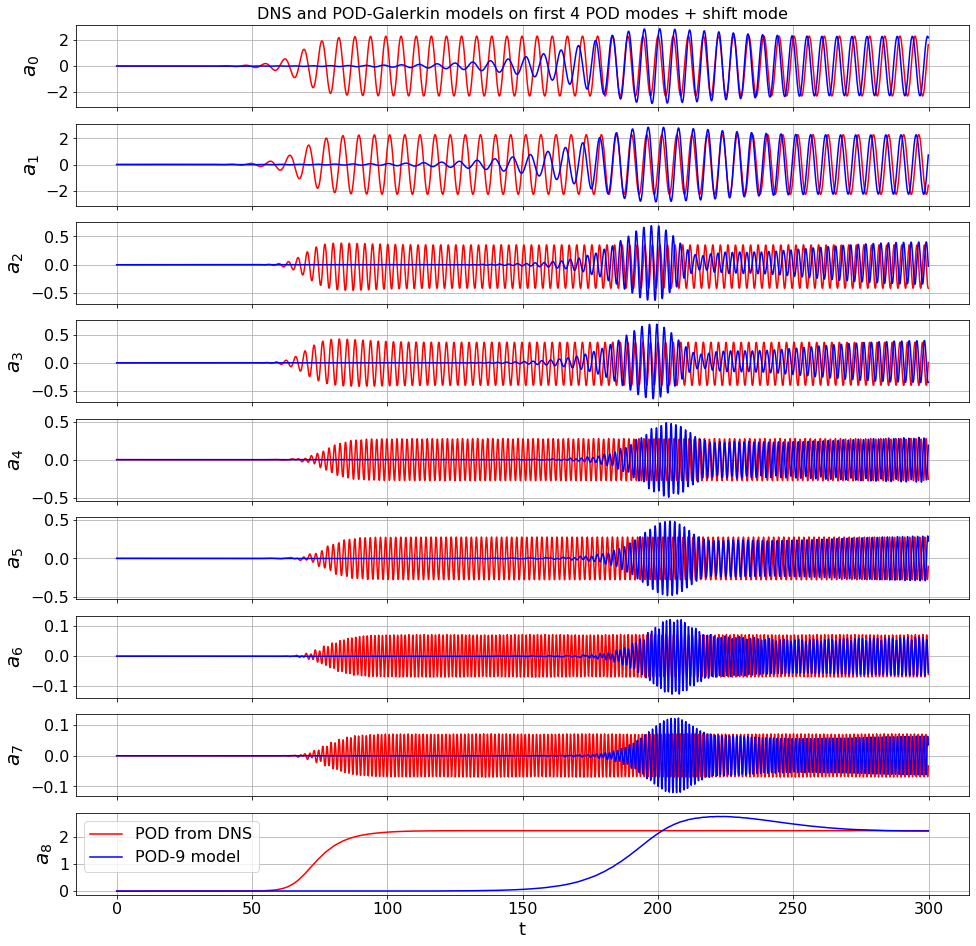

In [3]:
# define parameters and load in POD modes obtained from DNS
a = np.loadtxt('data/vonKarman_pod/vonKarman_a.dat')
t = a[:, 0]
r = 9
if r < 9:
    a_temp = a[:, 1:r]
    a_temp = np.hstack((a_temp, a[:, -1].reshape(3000, 1)))
    a = a_temp
else:
    a = a[:, 1:r + 1]
tbegin = 0
tend = 3000
skip = 1
t = t[tbegin:tend:skip]
a = a[tbegin:tend:skip, :]
dt = t[1] - t[0]

# define the POD-Galerkin models from Noack (2003)
galerkin3 = sio.loadmat('data/vonKarman_pod/galerkin3.mat')
model3 = lambda t, a: galerkin_model(a, galerkin3['L'], galerkin3['Q'])
galerkin9 = sio.loadmat('data/vonKarman_pod/galerkin9.mat')

# make the Galerkin model nonlinearity exactly energy-preserving 
# rather than just approximately energy-preserving
# gQ = 0.5 * (galerkin9['Q'] + np.transpose(galerkin9['Q'], [0, 2, 1]))
# print(gQ)
# galerkin9['Q'] = gQ - (gQ + np.transpose(gQ, [1, 0, 2]) + np.transpose(
#     gQ, [2, 1, 0]) + np.transpose(
#     gQ, [0, 2, 1]) + np.transpose(
#     gQ, [2, 0, 1]) + np.transpose(
#     gQ, [1, 2, 0])) / 6.0
model9 = lambda t, a: galerkin_model(a, galerkin9['L'], galerkin9['Q'])

# time base for simulating Galerkin models
t_sim = np.arange(0, 500, dt)

# Generate initial condition from unstable eigenvectors
lamb, Phi = np.linalg.eig(galerkin9['L'])
idx = np.argsort(-np.real(lamb))
lamb, Phi = lamb[idx], Phi[:, idx]
a0 = np.zeros(9)
a0[0] = 1e-3
# np.real( 1e-3 * Phi[:, :2] @ np.random.random((2)) )

# get the 5D POD-Galerkin coefficients
inds5 = np.ix_([0, 1, 2, 3, -1], [0, 1, 2, 3, -1])
galerkin5 = {}
galerkin5['L'] = galerkin9['L'][inds5]
inds5 = np.ix_([0, 1, 2, 3, -1], [0, 1, 2, 3, -1], [0, 1, 2, 3, -1])
galerkin5['Q'] = galerkin9['Q'][inds5]
model5 = lambda t, a: galerkin_model(a, galerkin5['L'], galerkin5['Q'])

# make the 3D, 5D, and 9D POD-Galerkin trajectories
t_span = (t[0], t[-1])
a_galerkin3 = solve_ivp(model3, t_span, a0[:3], t_eval=t, 
                        **integrator_keywords).y.T
a_galerkin5 = solve_ivp(model5, t_span, a0[:5], t_eval=t, 
                        **integrator_keywords).y.T
adot_galerkin5 = np.gradient(a_galerkin5, axis=0) / (t[1] - t[0])
a_galerkin9 = solve_ivp(model9, t_span, a0[:9], t_eval=t, 
                        **integrator_keywords).y.T
adot_galerkin9 = np.gradient(a_galerkin9, axis=0) / (t[1] - t[0])

# plot the first 4 POD modes + the shift mode
mode_numbers = range(10)
plt.figure(figsize=(16, 16))
for i in range(r):
    plt.subplot(r, 1, i + 1)
    if i == 0:
        plt.title('DNS and POD-Galerkin models on first 4 POD modes + shift mode', 
                  fontsize=16)
    plt.plot(t, a[:, mode_numbers[i]], 'r', label='POD from DNS')
    plt.plot(t, a_galerkin9[:, mode_numbers[i]], 'b', label='POD-9 model')
    ax = plt.gca()
    plt.ylabel(r'$a_{' + str(mode_numbers[i]) + '}$', fontsize=20)
    plt.grid(True)
    if i == r - 1:
        plt.xlabel('t', fontsize=18)
        plt.legend(loc='upper left', fontsize=16)
    else:
        ax.set_xticklabels([])
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
a0 = np.zeros(r)
a0[0] = 1e-3

### Compute the velocity, vorticity, and enstrophy

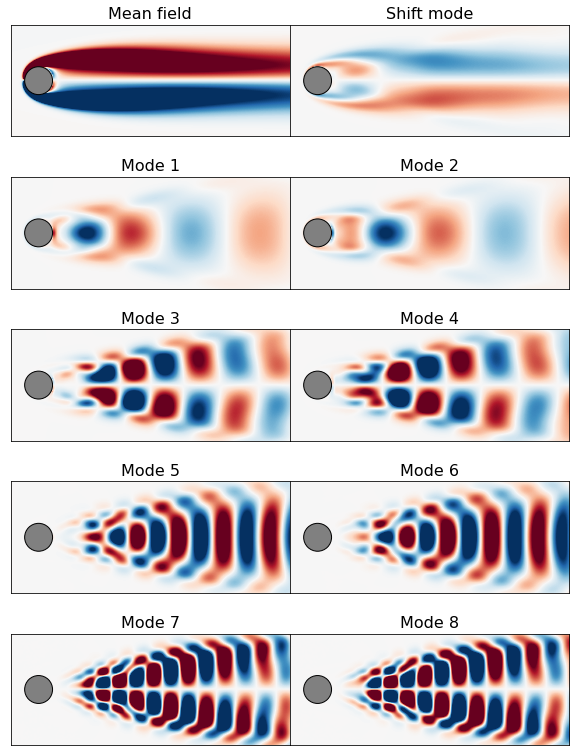

In [4]:
# path to POD mode files
field_path = 'data/vonKarman_pod/cyl0.snapshot'  
mode_path = 'data/vonKarman_pod/pod_modes/'  

# Read limit cycle flow field for grid points
field = nek.readnek(field_path)
nel = 2622  # Number of spectral elements
nGLL = 7  # Order of the spectral mesh
n = nel * nGLL ** 2

# define cell values needed for the vorticity interpolation
Cx = np.array([field.elem[i].pos[0, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])
Cy = np.array([field.elem[i].pos[1, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])

filename = lambda t_idx: 'cyl0.f{0:05d}'.format(t_idx)

# plot mean + leading POD modes
clim = [-1, 1]
file_order = [1, 10, 2, 3, 4, 5, 6, 7, 8, 9]
file_labels = ['Mean field', 'Shift mode', 'Mode 1', 'Mode 2', 'Mode 3', 
               'Mode 4', 'Mode 5', 'Mode 6', 'Mode 7', 'Mode 8']
fig = plt.figure(figsize=(10, 14))
spec = gridspec.GridSpec(ncols=2, nrows=5, figure=fig, hspace=0.0, wspace=0.0)
u_list = []
v_list = []
vorticities = []
vorticities_flat = []
for i in range(len(file_order)):
    plt.subplot(spec[i])
    u, v = get_velocity(mode_path + filename(file_order[i]))
    u_list.append(u)
    v_list.append(v)
    vort = interp( get_vorticity(mode_path + filename(file_order[i])) )
    vorticities.append(np.reshape(vort, [nx, ny], order='F').T)
    vorticities_flat.append(get_vorticity(mode_path + filename(file_order[i])))
    
    plot_field(np.reshape(vort, [nx, ny], order='F').T, clim=clim, 
               label=file_labels[i])
    plt.xlim([-1, 9])
    plt.ylim([-2, 2])
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title(file_labels[i], fontsize=16)

plt.show()

In [5]:
mass_matrix = np.loadtxt('data/vonKarman_pod/pod_modes/mass_matrix.dat')
ip1 = lambda a, b: np.dot(mass_matrix * a, b)
ip2 = lambda a, b, c, d: np.dot(a * mass_matrix, c) + np.dot(b * mass_matrix, d)
energy_integrals = np.zeros((10, 10))
enstrophy_integrals = np.zeros((10, 10))
mode5_integrals = np.zeros((5, 5))
mstar_enstrophy = np.zeros(10)
for i, wi in enumerate(vorticities_flat):
    for j, wj in enumerate(vorticities_flat):
        if i == 0:
            enstrophy_integrals[i, j] = ip2(u_list[i], v_list[i], wj, wj)
        else:
            enstrophy_integrals[i, j] = ip1(wi, wj)
        energy_integrals[i, j] = ip2(u_list[i], v_list[i], u_list[j], v_list[j])
        if i > 0 and (i < 5 or i == 9):
            if j > 0 and j < 5 and i < 5:
                mode5_integrals[i - 1, j - 1] = enstrophy_integrals[i, j]
            if j == 9 and i < 5:
                mode5_integrals[i - 1, -1] = enstrophy_integrals[i, j]
            if j > 0 and j < 5 and i == 9:
                mode5_integrals[- 1, j - 1] = enstrophy_integrals[i, j]
            if j == 9 and i == 9:
                mode5_integrals[-1, -1] = enstrophy_integrals[i, j]

In [6]:
# Compute the energy eigenvalues 
# (should be identity because we are already in the eigenbasis of energy)
P_energy = energy_integrals[1:, 1:]
eigs_energy, eigvecs_energy = np.linalg.eigh(P_energy)
eigs_energy  # symmetric, positive definite matrix, yay!

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [7]:
# Compute the enstrophy eigenvalues 
# (should be all positive since enstropy is pos. definite)
P_enstrophy = enstrophy_integrals[1:, 1:]
eigs_enstrophy, eigvecs_enstrophy = np.linalg.eigh(P_enstrophy)
print(eigs_enstrophy)  # symmetric, positive definite matrix, yay!
L_enstrophy = np.dot(P_enstrophy, galerkin9['L'])

[ 2.67263044  2.77586845  2.99679269 10.56613702 10.72350858 16.37472198
 16.41514671 31.23187078 31.24605304]


In [8]:
# Run simulated annealing algorithm for both energy and enstrophy
from scipy.optimize import dual_annealing as anneal_algo
r = 9

# define the objective function to be minimized by simulated annealing
def obj_function(m, L_obj, Q_obj, P_obj):
    As = L_obj - P_obj @ np.tensordot(m, Q_obj,axes=([0], [0]))
    eigvals, eigvecs = np.linalg.eigh(As)
    return(eigvals[-1])


# Search between -500, 500 for each component of m
boundvals = np.zeros((r, 2))
boundmax = 5000
boundmin = -5000
boundvals[:, 0] = boundmin
boundvals[:, 1] = boundmax

# run simulated annealing and display optimal m and 
# the corresponding objective function value
Ls = 0.5 * (L_enstrophy + L_enstrophy.T)
algo_sol = anneal_algo(obj_function, bounds=boundvals, 
                       args=(Ls, galerkin9['Q'], P_enstrophy), maxiter=2000)
opt_m = algo_sol.x
opt_energy = algo_sol.fun
opt_result = algo_sol.message
print('Enstrophy result:')
print('Simulated annealing ended because ' + opt_result[0])
print('Optimal m = ', opt_m)
print('Algorithm managed to reduce the largest eigenvalue of A^S to eig1 = ', 
      opt_energy)

# Repeat using the energy
Ls = 0.5 * (galerkin9['L'] + galerkin9['L'].T)
algo_sol = anneal_algo(obj_function, bounds=boundvals, 
                       args=(Ls, galerkin9['Q'], P_energy), maxiter=2000)
opt_m = algo_sol.x
opt_energy = algo_sol.fun
opt_result = algo_sol.message
print('Energy result:')
print('Simulated annealing ended because ' + opt_result[0])
print('Optimal m = ', opt_m)
print('Algorithm managed to reduce the largest eigenvalue of A^S to eig1 = ', 
      opt_energy)

Enstrophy result:
Simulated annealing ended because Maximum number of iteration reached
Optimal m =  [-0.15266223 -1.00347068 -0.06129968 -0.11213085 -0.37095032  0.33065798
 -0.03935889 -0.02935052  8.10911764]
Algorithm managed to reduce the largest eigenvalue of A^S to eig1 =  5.980769374696902


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-afeded44df5d>", line 36, in <module>
    args=(Ls, galerkin9['Q'], P_energy), maxiter=2000)
  File "/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/optimize/_dual_annealing.py", line 683, in dual_annealing
    val = strategy_chain.local_search()
  File "/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/optimize/_dual_annealing.py", line 348, in local_search
    e, x = self.minimizer_wrapper.local_search(self.xmin, self.emin)
  File "/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/optimize/_dual_annealing.py", line 416, in local_search
    mres = self.minimizer(self.func_wrapper.fun, x, **self.kwargs)
  File "/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py", li

KeyboardInterrupt: 

In [ ]:
Ls_enstrophy = 0.5 * (L_enstrophy + L_enstrophy.T)
Ls_energy = 0.5 * (galerkin9['L'] + galerkin9['L'].T)
N = 5000
alphas = np.linspace(0, 100, N)
m = np.zeros(9)
m_enstrophy = m
m_enstrophy[:-1] = [2.23152156e-03,  2.00115034e-02,  
                    7.35644858e-01,  2.58211038e-01,
                    1.11620562e-02, -2.61256117e-02, 
                    -3.10818303e-02,  6.95449745e-02]
obj_energy = np.zeros(N)
obj_enstrophy = np.zeros(N)
Rm_energy = np.zeros(N)
Rm_enstrophy = np.zeros(N)

# Extract maximum and minimum eigenvalues, 
# and compute radius of the trapping region
max_eig_energy = np.sort(eigs_energy)[-1]
max_eig_enstrophy = np.sort(eigs_enstrophy)[-1]

for i, alpha in enumerate(alphas):
    m[-1] = alpha
    m_enstrophy[-1] = alpha
    obj_energy[i] = obj_function(m, Ls_energy, 
                                 galerkin9['Q'], P_energy)
    obj_enstrophy[i] = obj_function(m_enstrophy, Ls_enstrophy, 
                                    galerkin9['Q'], P_enstrophy)
    d_energy = np.dot(galerkin9['L'], m) + np.dot(
        np.tensordot(galerkin9['Q'], m, axes=([2], [0])), m)
    d_enstrophy = np.dot(L_enstrophy, m_enstrophy) + np.dot(
        np.tensordot(galerkin9['Q'], m_enstrophy, 
                     axes=([2], [0])), m_enstrophy)
    Rm_energy[i] = np.linalg.norm(d_energy) / np.abs(obj_energy[i])
    Rm_enstrophy[i] = np.linalg.norm(d_enstrophy) / np.abs(obj_enstrophy[i])


In [ ]:
mstar_energy = -energy_integrals[0, 1:]
mstar_energy = np.concatenate([mstar_energy[1:], [mstar_energy[0]]])
print(mstar_energy)
### Only need to calculate if rotated into enstrophy basis
mstar_enstrophy = -enstrophy_integrals[0, 1:]
mstar_enstrophy = np.concatenate([mstar_enstrophy[1:], [mstar_enstrophy[0]]])
print(mstar_enstrophy)

In [ ]:
plt.figure(figsize=(6, 5))
plt.plot(alphas, obj_energy * 1e2, label='$\lambda_1^W$ x $10^2$')
plt.plot(alphas[obj_energy < 0], Rm_energy[obj_energy < 0] / 1.0e2, 
         label='$R_m^W$ x $10^{-2}$')
plt.plot(alphas, obj_enstrophy, label='$\lambda_1^{H_e}$')
plt.plot(alphas[obj_enstrophy < 0], Rm_enstrophy[obj_enstrophy < 0] / 1.0e2, 
         label='$R_m^{H_e}$ x $10^{-2}$')
# plt.scatter(mstar_energy[-1], 
#             obj_function(mstar_energy, Ls_energy, galerkin9['Q'], 
#                          P_energy), color='b')
# plt.scatter(mstar_enstrophy[-1], 
#             obj_function(mstar_enstrophy, Ls_enstrophy, galerkin9['Q'], 
#                          P_enstrophy), color='g')
plt.legend(fontsize=14)
plt.ylim(-5, 20)
plt.grid(True)
plt.xlabel(r'$\alpha$', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('9mode_summary.pdf')

In [ ]:
# same test and train trajectory for simplicity here
r = 5
if r < 9:
    a_temp = a[:, :r - 1]
    a_temp = np.hstack((a_temp, a[:, -1].reshape(3000, 1)))
    x_train = a_temp
for i in range(5):
    plt.plot(x_train[:, i])

In [ ]:
max_iter = 120
eta = 1.0
threshold = 0.1
alpha_m = 5e-1 * eta

constraint_zeros, constraint_matrix = make_constraints(r)

# run trapping SINDy
sindy_opt = ps.TrappingGeneralizedSR3(
    threshold=threshold, eta=eta,
    alpha_m=alpha_m,
    max_iter=max_iter,
    constraint_lhs=constraint_matrix,
    constraint_rhs=constraint_zeros,
    constraint_order="feature",
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(x_train, t=t)
Xi = model.coefficients().T
PL_tensor = sindy_opt.PL_
PQ_tensor = sindy_opt.PQ_
Lenergy = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Qenergy = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
mean_val = np.mean(x_train, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_stability(r, Xi, np.eye(r), sindy_opt, mean_val)
energy_model = model

In [ ]:
# Repeat trapping SINDy using the enstrophy
mod_matrix = mode5_integrals

max_iter = 1  # 100000
eta = 1.0e3  # 1e4
threshold = 0.5  # threshold = 0
alpha_m = eta * 40

sindy_opt = ps.TrappingGeneralizedSR3(
    threshold=threshold, eta=eta, 
    alpha_m=alpha_m,
    m0=[-0.39752172, -0.44292986, 4.61711971, -1.86506372, 10.26875058],
    max_iter=max_iter,
    constraint_lhs=constraint_matrix,
    constraint_rhs=constraint_zeros,
    constraint_order="feature",
    mod_matrix=mod_matrix,
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(x_train, t=t)
Xi = model.coefficients().T
Lenstrophy = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Qenstrophy = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
mean_val = np.mean(x_train, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_stability(r, Xi, mod_matrix, sindy_opt, mean_val)
enstrophy_model = model

In [ ]:
energy_model.print()
enstrophy_model.print()
make_bar(galerkin5, Lenergy, Qenergy, Lenstrophy, Qenstrophy)

In [ ]:
# x_train = a
x_test = x_train
xdot_test = model.differentiate(x_test, t=t)
xdot_train = model.differentiate(x_train, t=t)
xdot_test_pred = model.predict(x_test)
xdot_train_pred = model.predict(x_train)
x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(a0[:r], t, integrator_kws=integrator_keywords)

# plotting and analysis
make_fits(r, t, xdot_train, xdot_train_pred, x_train, x_train_pred, 'vonKarman')

In [ ]:
# Interpolate onto better time base
t_traj = np.linspace(t[0], t[-1], len(t) * 1)

# random initial condition near to origin
a0 = a[0, :r]  #(np.random.rand(r) - 0.5) * 2.0

# simulate trapping SINDy results
xtraj_energy = energy_model.simulate(a0, t_traj)
xtraj_enstrophy = enstrophy_model.simulate(a0, t_traj)

# simulate and plot 9D POD-Galerkin results
a0_galerkin9 = np.zeros(9)
a0_galerkin9[:r-1] = a0[:-1]
a0_galerkin9[-1] = a0[-1]
a0_galerkin5 = a0
t_span = (t_traj[0], t_traj[-1])
xtraj_pod9 = solve_ivp(model5, t_span, a0_galerkin5, t_eval=t_traj, 
                       **integrator_keywords).y.T
# x_test = a

# Make awesome plot
fig, ax = plt.subplots(3, 3, subplot_kw={'projection': '3d'}, figsize=(16, 16))
data = [x_test[:, [0, 1, -1]], xtraj_energy[:, [0, 1, -1]], 
        x_test[:, [0, 1, -1]], xtraj_pod9[:, [0, 1, -1]], 
        x_test[:, [0, 1, -1]], xtraj_enstrophy[:, [0, 1, -1]],
        x_test[:, [0, 1, 2]], xtraj_energy[:, [0, 1, 2]], 
        x_test[:, [0, 1, 2]], xtraj_pod9[:, [0, 1, 2]], 
        x_test[:, [0, 1, 2]], xtraj_enstrophy[:, [0, 1, 2]], 
        x_test[:, [2, 3, -1]], xtraj_energy[:, [2, 3, -1]], 
        x_test[:, [2, 3, -1]], xtraj_pod9[:, [2, 3, -1]],
        x_test[:, [2, 3, -1]], xtraj_enstrophy[:, [2, 3, -1]]]
data_labels = [[r'$a_1$', r'$a_2$', r'$a_{-1}$'], 
               [r'$a_1$', r'$a_2$', r'$a_3$'], 
               [r'$a_2$', r'$a_3$', r'$a_{-1}$']]
for i in range(3):
    ax[i, 0].plot(data[6 * i][:, 0], data[6 * i][:, 1], data[6 * i][:, 2], 
                  color='r', label='POD trajectory from DNS')
    ax[i, 0].plot(data[6 * i + 1][:, 0], data[6 * i + 1][:, 1], 
                  data[6 * i + 1][:, 2],
                  color='k', label='Trapping SINDy model (energy)')
    ax[i, 1].plot(data[6 * i + 2][:, 0], data[6 * i + 2][:, 1], 
                  data[6 * i + 2][:, 2],
                  color='r', label='POD trajectory from DNS')
    ax[i, 1].plot(data[6 * i + 3][:, 0], data[6 * i + 3][:, 1], 
                  data[6 * i + 3][:, 2],
                  color='b', label='(analytic) POD-Galerkin model')
    ax[i, 2].plot(data[6 * i + 4][:, 0], data[6 * i + 4][:, 1], 
                  data[6 * i + 4][:, 2],
                  color='r', label='POD trajectory from DNS')
    ax[i, 2].plot(data[6 * i + 5][:, 0], data[6 * i + 5][:, 1], 
                  data[6 * i + 5][:, 2],
                  color='g', label='Trapping SINDy model (enstrophy)')
    ax[i, 0].legend(fontsize=10)
    ax[i, 0].set_xticklabels([])
    ax[i, 0].set_yticklabels([])
    ax[i, 0].set_zticklabels([])
    ax[i, 0].set_xlabel(data_labels[i][0], fontsize=14)
    ax[i, 0].set_ylabel(data_labels[i][1], fontsize=14)
    ax[i, 0].set_zlabel(data_labels[i][2], fontsize=14)
    ax[i, 1].legend(fontsize=10)
    ax[i, 1].set_xticklabels([])
    ax[i, 1].set_yticklabels([])
    ax[i, 1].set_zticklabels([])
    ax[i, 1].set_xlabel(data_labels[i][0], fontsize=14)
    ax[i, 1].set_ylabel(data_labels[i][1], fontsize=14)
    ax[i, 1].set_zlabel(data_labels[i][2], fontsize=14)
    ax[i, 2].legend(fontsize=10)
    ax[i, 2].set_xticklabels([])
    ax[i, 2].set_yticklabels([])
    ax[i, 2].set_zticklabels([])
    ax[i, 2].set_xlabel(data_labels[i][0], fontsize=14)
    ax[i, 2].set_ylabel(data_labels[i][1], fontsize=14)
    ax[i, 2].set_zlabel(data_labels[i][2], fontsize=14)
plt.show()

In [ ]:
eigs5, eigvecs5 = np.linalg.eigh(mode5_integrals)
eigs5

In [ ]:
## Todo:
# 1. Add mass matrix to paper -- done but check mass matrix for von Karman
# 2. Figure out mstar for enstrophy and why doesn't agree
# 3. done -- Get 5-mode models working for both energy and enstrophy + compare
# 4. Finalize von Karman section
# 5. Polish up paper so is ready-to-go except the plasma example
# 6. done -- Make clear that in enstrophy case, can either transform basis into eigenbasis 
#    of the enstrophy and then do normal trapping (A^S unmodified) using
#    the vorticity POD modes (need to fix the model coefficients?), or can use 
#    original basis of POD modes and do trapping with PA^S.
# 7. done -- Show P_ij * Q_ijk a_i a_j a_k = 0

In [ ]:
plt.plot(t, np.sum(a ** 2, axis=1))
enstrophy_time = np.zeros(len(t))
for i in range(len(t)):
    enstrophy_time[i] = a[i, :] @ P_enstrophy @ a[i, :].T
plt.plot(t, enstrophy_time)

In [ ]:
from matplotlib import animation

# Define the full u(x, y, t) fields for the DNS, POD-Galerkin reconstruction
# and trapping SINDy reconstruction. 
u_true = np.zeros((vort.shape[0], a.shape[0]))
u_galerkin = np.zeros((vort.shape[0], a_galerkin9.shape[0]))
u_energy = np.zeros((vort.shape[0], a.shape[0]))
u_enstrophy = np.zeros((vort.shape[0], a.shape[0]))
n = 128478
r = 5
Psi = np.zeros([n, r])
Psi0 = get_vorticity(mode_path + filename(1))
for i in range(r - 1):
    Psi[:, i] = get_vorticity(mode_path + filename(i + 2))

Psi[:, -1] = get_vorticity(mode_path + filename(10))
    
# for reconstruction with the shift-mode
Psi0 = get_vorticity(mode_path + filename(1))
Psi_mean = np.outer(Psi0, np.ones(x_test.shape[0]))
u_true = Psi_mean + Psi @ x_test.T
u_energy = Psi_mean + Psi @ xtraj_energy.T
u_enstrophy = Psi_mean + Psi @ xtraj_enstrophy.T
Psi_mean = np.outer(Psi0, np.ones(a_galerkin5.shape[0]))
u_galerkin = Psi_mean + Psi @ a_galerkin5.T

# make the animation
fps = 30
fig = plt.figure(1, figsize=(16, 8) )
# plot DNS 
clim = [-3, 3]
tbegin = 400
tend = 2500
plt.subplot(2, 2, 1)
im1 = plot_field(np.reshape(interp(u_true[:, tbegin]), [nx, ny], order='F').T, 
                 clim=clim, label='DNS')
plt.xlim([-1, 9])
plt.ylim([-2, 2])
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
#ax.set_title('t = {0:.2f}'.format(t[tbegin]))
plt.xlabel('DNS', fontsize=18)
# plot POD-Galerkin reconstruction
plt.subplot(2, 2, 2)
im2 = plot_field(np.reshape(interp(u_galerkin[:, tbegin]), [nx, ny], order='F').T, 
                 clim=clim, label='POD-9')
plt.xlim([-1, 9])
plt.ylim([-2, 2])
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.xlabel('POD-5', fontsize=18)
# plot trapping SINDy reconstruction
plt.subplot(2, 2, 3)
im3 = plot_field(np.reshape(interp(u_energy[:, tbegin]), [nx, ny], order='F').T, 
                 clim=clim, label='Trapping SINDy (energy)')
plt.xlim([-1, 9])
plt.ylim([-2, 2])
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.xlabel('Trapping SINDy (energy)', fontsize=18)
plt.subplot(2, 2, 4)
im4 = plot_field(np.reshape(interp(u_enstrophy[:, tbegin]), [nx, ny], order='F').T, 
                 clim=clim, label='Trapping SINDy (enstrophy)')
plt.xlim([-1, 9])
plt.ylim([-2, 2])
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.xlabel('Trapping SINDy (enstrophy)', fontsize=18)
# switch back to subplot 1 
# plt.subplot(2, 2, 1)
# ax = plt.gca()


# animation function for looping through frames
def animate_func(i):
    if i % 100:
        print(i)
    plt.suptitle('t = {0:.2f}'.format(t[i]), fontsize=18)
    im1.set_array(np.reshape(interp(u_true[:, i]), [nx, ny], order='F').T)
    im2.set_array(np.reshape(interp(u_galerkin[:, i]), [nx, ny], order='F').T)
    im3.set_array(np.reshape(interp(u_energy[:, i]), [nx, ny], order='F').T)
    im4.set_array(np.reshape(interp(u_enstrophy[:, i]), [nx, ny], order='F').T)
    return [im1, im2, im3]


# anim = animation.FuncAnimation(fig, 
#                                animate_func, 
#                                frames = np.arange(tbegin, tend, 2),
#                                interval = 200)
# anim.save('vonKarman_meanfield.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

In [ ]:
# Want to plot 2D version of K, Kdot, Kddot
model5 = lambda a: galerkin_model(a, galerkin5['L'], galerkin5['Q'])
def galerkin_Kdot_model(a, L, Q):
    """RHS of POD-Galerkin model, for time integration"""
    return a @ (L @ a) + Q @ a @ a @ a
def galerkin_ddot_model(a, L, Q):
    """RHS of POD-Galerkin model, for time integration"""
    return 2 * (L @ a) + 3 * np.einsum('ijk,j,k->i', Q, a, a)
ddot_model5 = lambda a: galerkin_ddot_model(a, galerkin5['L'], galerkin5['Q'])
Kdot_model = lambda a: galerkin_Kdot_model(a, galerkin5['L'], galerkin5['Q'])
N1 = 100
N2 = N1
y1 = np.linspace(-5e4, 5e4, N1)
y2 = np.linspace(-5e4, 5e4, N2)
K = np.zeros((N1, N2))
Kdot = np.zeros((N1, N2))
Kddot = np.zeros((N1, N2))
for i in range(N1):
    for j in range(N2):
        y = [y1[i], y2[j], 0, 0, 0]
        K[i, j] = (y1[i] ** 2 + y2[j] ** 2) / 2.0
        y_dot = model5(y)
        Kdot[i, j] = Kdot_model(y)  #np.dot(y, y_dot)
        Kddot[i, j] = np.dot(ddot_model5(y), y_dot) 

In [ ]:
plt.pcolormesh(y1, y2, K)
plt.colorbar()

In [ ]:
plt.pcolormesh(y1, y2, Kdot > 0)
#plt.colorbar()

In [ ]:
plt.pcolormesh(y1, y2, Kddot)
plt.colorbar()

In [ ]:
Q_12 = galerkin5['Q'][0:2, 0:2, 0:2]
L_12 = galerkin5['L'][0:2, 0:2]

In [ ]:
print(L_12)

In [ ]:
print(Q_12)

In [12]:
print(np.max(gQ + np.transpose(gQ, [1, 0, 2]) + np.transpose(
    gQ, [2, 1, 0]) + np.transpose(
    gQ, [0, 2, 1]) + np.transpose(
    gQ, [2, 0, 1]) + np.transpose(
    gQ, [1, 2, 0])) / 6.0)
print(np.linalg.norm(galerkin5['L']) / 0.0003931843531373586)

0.0003931843531373586
6211.224590148236


In [ ]:
y_initial_unbounded = [-10000,
y2 = 20000
unbounded_galerkin5 = solve_ivp(model5, t_span, a0[:5], t_eval=t, 
                        **integrator_keywords).y.T